### This is the DeepLab3+ base model


<details>
  <summary>Model Architechture</summary>
  
  - Model Definition: DeepLabV3Plus with 3 input channels.
  
  - Traning Setup
        - num_epochs = 50 
        - eary stop mechanism kicks in when improvement_tolerance = 0.00001 is not satisfied.  #  Need to add to the code. 
        - learning_rate = 0.001
        - patience = 3 # number of epochs with no change before early stop
        - criterion = nn.CrossEntropyLoss()
        - optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        - scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  
  - Saver the initial state of the model before training
        - When loaded before each experiment will reset the state of the model and reinitialize optimizer and learning rate schedulers
          
  - Evaluation Metrics
        - Dice Coefficient (F1 Score)
        - Jaccard
        - Precision
        - Recall
        - Accuracy
        - Loss
</details>




In [1]:
#%pip install -U albumentations

In [2]:
# imports

import csv
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
from albumentations import Compose as AlbCompose, Resize as AlbResize, Normalize as AlbNormalize
import matplotlib.pyplot as plt

# Import DeepLabV3+ Model
from segmentation_models_pytorch import DeepLabV3Plus

c:\Users\ssrir\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:

# Define device and initialize DeepLabV3+ Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLabV3Plus(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=2)
model.to(device)

#load the model
def load_initial_model_state(model, filepath='initial_deeplab_model.pth'):
    model.load_state_dict(torch.load(filepath, weights_only=True))
    model.eval()  # Set the model to evaluation mode
    print("Initial model state loaded!")

# Training setup
#num_epochs = 5  # use for testing the code.
num_epochs = 50  # normally 50 epochs
learning_rate = 0.001
improvement_tolerance = 0.0001  # Minimum improvement required to reset the counter
# improvement_tolerance = 0.00001  # Use this for the final run of the model on Google Colab ????
patience = 3 # Number of epochs to wait for improvement before early stopping
# patience = 5 # Use this for final run of the model on Google Colab ????
criterion = nn.CrossEntropyLoss()

# Initialize metric lists to store the results.
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_jaccards, test_jaccards = [], []
train_precisions, test_precisions = [], []
train_recalls, test_recalls = [], []
train_dices, test_dices = [], []

# Data transformations
def get_transforms():
    return AlbCompose([
        AlbResize(height=256, width=256, interpolation=1),  # 1 corresponds to 'bilinear'
        AlbNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])


# Define activation functions to experiment with
activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]

# Function to set activation in the model
def set_activation_function(model, activation_function):
    """This function replaces the activation layers in the model with a specified activation function."""
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            # Replace ReLU with the specified activation function
            setattr(model, name, activation_function)
        elif isinstance(module, nn.Sigmoid):
            # Replace Sigmoid with the specified activation function
            setattr(model, name, activation_function)
        elif isinstance(module, nn.Tanh):
            # Replace Tanh with the specified activation function
            setattr(model, name, activation_function)


# Dataset Class
class KvasirDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        with open(file_list, 'r') as f:
            self.image_filenames = f.read().splitlines()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.images_dir, self.image_filenames[idx] + '.jpg')).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, self.image_filenames[idx] + '.png')).convert("L")

        # Convert images to numpy arrays
        image_np = np.array(image)
        mask_np = np.array(mask)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)  # Use the correct keyword arguments
            image, mask = augmented['image'], augmented['mask']

        mask = (mask > 0).astype(np.int64)  # Convert mask to binary (0 or 1)

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Change shape to C x H x W
        mask = torch.tensor(mask, dtype=torch.long)  # Keep mask as long for class indices

        return image, mask

# Load datasets and define data loaders
train_dataset = KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/train.txt', transform=get_transforms())
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataset = KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/test.txt', transform=get_transforms())
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Metrics functions
def calculate_accuracy(preds, targets):
    correct = (preds == targets).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy

def calculate_metrics(preds, targets):
    """Calculate Jaccard, Precision, Recall, Accuracy, and Dice Coefficient for binary classification."""
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    jaccard = jaccard_score(targets_flat, preds_flat, average='binary')
    precision = precision_score(targets_flat, preds_flat, zero_division=0)
    recall = recall_score(targets_flat, preds_flat, zero_division=0)
    accuracy = (preds_flat == targets_flat).sum() / len(targets_flat)

    # Dice Coefficient as F1 Score in binary case
    dice = f1_score(targets_flat, preds_flat, average='binary')

    return jaccard, precision, recall, accuracy, dice


def train_and_evaluate(model, train_loader, test_loader, activation_function):
    # Initialize the results dictionary to store metrics
    results = {
        'train_losses': [],
        'test_losses': [],
        'train_accuracies': [],
        'test_accuracies': [],
        'train_jaccards': [],
        'test_jaccards': [],
        'train_precisions': [],
        'test_precisions': [],
        'train_recalls': [],
        'test_recalls': [],
        'train_dices': [],
        'test_dices': [],
    }
    
    best_test_loss = float('inf')
    early_stop_counter = 0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_acc = 0.0, 0.0
        all_train_jaccard, all_train_precision, all_train_recall, all_train_dice = [], [], [], []

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            running_loss += loss.item()
            running_acc += calculate_accuracy(preds, masks).item()

            # Calculate training metrics
            jaccard, precision, recall, _, dice = calculate_metrics(preds.cpu().numpy(), masks.cpu().numpy())
            all_train_jaccard.append(jaccard)
            all_train_precision.append(precision)
            all_train_recall.append(recall)
            all_train_dice.append(dice)

        # Log training metrics
        avg_train_loss = running_loss / len(train_loader)
        avg_train_acc = running_acc / len(train_loader)
        avg_train_jaccard = sum(all_train_jaccard) / len(all_train_jaccard)
        avg_train_precision = sum(all_train_precision) / len(all_train_precision)
        avg_train_recall = sum(all_train_recall) / len(all_train_recall)
        avg_train_dice = sum(all_train_dice) / len(all_train_dice)

        results['train_losses'].append(avg_train_loss)
        results['train_accuracies'].append(avg_train_acc)
        results['train_jaccards'].append(avg_train_jaccard)
        results['train_precisions'].append(avg_train_precision)
        results['train_recalls'].append(avg_train_recall)
        results['train_dices'].append(avg_train_dice)

        # Validation/Test Step
        model.eval()
        with torch.no_grad():
            running_test_loss, running_test_acc = 0.0, 0.0
            all_jaccard, all_precision, all_recall, all_accuracy, all_dice = [], [], [], [], []

            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                test_loss = criterion(outputs, masks)
                running_test_loss += test_loss.item()

                preds = torch.argmax(outputs, dim=1)
                jaccard, precision, recall, accuracy, dice = calculate_metrics(preds.cpu().numpy(), masks.cpu().numpy())
                all_jaccard.append(jaccard)
                all_precision.append(precision)
                all_recall.append(recall)
                all_accuracy.append(accuracy)
                all_dice.append(dice)

            # Average metrics
            avg_test_loss = running_test_loss / len(test_loader)
            avg_test_acc = sum(all_accuracy) / len(all_accuracy)
            avg_jaccard = sum(all_jaccard) / len(all_jaccard)
            avg_precision = sum(all_precision) / len(all_precision)
            avg_recall = sum(all_recall) / len(all_recall)
            avg_dice = sum(all_dice) / len(all_dice)

            # Log test metrics
            results['test_losses'].append(avg_test_loss)
            results['test_accuracies'].append(avg_test_acc)
            results['test_jaccards'].append(avg_jaccard)
            results['test_precisions'].append(avg_precision)
            results['test_recalls'].append(avg_recall)
            results['test_dices'].append(avg_dice)

            # Print metrics after each epoch
            print(f"Epoch [{epoch + 1}/{num_epochs}]:")
            print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")
            print(f"  Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

            # Check for early stopping with improvement tolerance
            if avg_test_loss < best_test_loss - improvement_tolerance:
                best_test_loss = avg_test_loss
                early_stop_counter = 0
                torch.save({'model_state_dict': model.state_dict(),
                             'optimizer_state_dict': optimizer.state_dict(),
                             'epoch': epoch + 1,
                             'test_loss': avg_test_loss,
                             'test_accuracy': avg_test_acc,
                             'jaccard': avg_jaccard,
                             'precision': avg_precision,
                             'recall': avg_recall,
                             'dice': avg_dice}, 'deeplab_best_model.pth')
                print("Best model saved!")
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1} due to lack of improvement.")
                    break
        scheduler.step()

    return results  # Return the dictionary of all metrics

## Call the functions train, evaluate and plot results.

In [4]:
"""
Changes from the mainModel:

- Added the activation functions to the model
    activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
    located above KvasirDataset

- Function to set activation in the model
    def set_activation_function(model, activation_function):
    located above KvasirDataset


Epochs vary before the ES.
Output:
- 3x .pth files: Creates best model output file with the best model and its metrics, for each activation function,
- 1x .csv file:  and a csv file with the metrics for each epoch.

Last run: 
ReLU:         Early stopping at epoch 6 due to lack of improvement.
Sigmoid :     Early stopping at epoch 6 due to lack of improvement.
Tanh:         Early stopping at epoch 14 due to lack of improvement.
"""



# Initialize the results dictionary to store metrics for each activation function
activation_metrics = {}

# Train and evaluate the model for each activation function
for activation in activation_functions:
    # Reset the model to the initial state
    load_initial_model_state(model)
    print(f"Training with {activation.__class__.__name__} activation function...") # print current activation function
    results = train_and_evaluate(model, train_loader, test_loader, activation_function=activation) # store results in a dictionary
    activation_metrics[activation.__class__.__name__] = results # store the results in the main dictionary for all activation functions

# Save results to a CSV file
with open('activation_function_results.csv', mode='w', newline='') as csvfile:
    fieldnames = ["Activation Function", "Epoch", "Train Loss", "Test Loss", 
                  "Train Accuracy", "Test Accuracy", "Train Jaccard", "Test Jaccard",
                  "Train Precision", "Test Precision", "Train Recall", "Test Recall",
                  "Train Dice", "Test Dice"]
    
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write the header
    writer.writeheader()
    
    # Write the rows for each activation function
    for activation_name, metrics in activation_metrics.items():
        for epoch in range(len(metrics['train_losses'])):
            writer.writerow({
                "Activation Function": activation_name,
                "Epoch": epoch + 1,
                "Train Loss": metrics['train_losses'][epoch],
                "Test Loss": metrics['test_losses'][epoch],
                "Train Accuracy": metrics['train_accuracies'][epoch],
                "Test Accuracy": metrics['test_accuracies'][epoch],
                "Train Jaccard": metrics['train_jaccards'][epoch],
                "Test Jaccard": metrics['test_jaccards'][epoch],
                "Train Precision": metrics['train_precisions'][epoch],
                "Test Precision": metrics['test_precisions'][epoch],
                "Train Recall": metrics['train_recalls'][epoch],
                "Test Recall": metrics['test_recalls'][epoch],
                "Train Dice": metrics['train_dices'][epoch],
                "Test Dice": metrics['test_dices'][epoch],
            })


Initial model state loaded!
Training with ReLU activation function...


Epoch 1/50: 100%|██████████| 59/59 [02:29<00:00,  2.53s/it]


Epoch [1/50]:
  Train Loss: 0.1515, Train Accuracy: 0.9466
  Test Loss: 0.1838, Test Accuracy: 0.9569
Best model saved!


Epoch 2/50: 100%|██████████| 59/59 [02:31<00:00,  2.57s/it]


Epoch [2/50]:
  Train Loss: 0.0802, Train Accuracy: 0.9698
  Test Loss: 0.0667, Test Accuracy: 0.9769
Best model saved!


Epoch 3/50: 100%|██████████| 59/59 [02:26<00:00,  2.48s/it]


Epoch [3/50]:
  Train Loss: 0.0684, Train Accuracy: 0.9746
  Test Loss: 0.0840, Test Accuracy: 0.9732


Epoch 4/50: 100%|██████████| 59/59 [02:39<00:00,  2.70s/it]


Epoch [4/50]:
  Train Loss: 0.0608, Train Accuracy: 0.9776
  Test Loss: 0.0582, Test Accuracy: 0.9801
Best model saved!


Epoch 5/50: 100%|██████████| 59/59 [03:51<00:00,  3.92s/it]


Epoch [5/50]:
  Train Loss: 0.0568, Train Accuracy: 0.9789
  Test Loss: 0.0513, Test Accuracy: 0.9842
Best model saved!


Epoch 6/50: 100%|██████████| 59/59 [03:55<00:00,  3.99s/it]


Epoch [6/50]:
  Train Loss: 0.0540, Train Accuracy: 0.9800
  Test Loss: 0.0799, Test Accuracy: 0.9730


Epoch 7/50: 100%|██████████| 59/59 [04:12<00:00,  4.27s/it]


Epoch [7/50]:
  Train Loss: 0.0503, Train Accuracy: 0.9811
  Test Loss: 0.0602, Test Accuracy: 0.9795


Epoch 8/50: 100%|██████████| 59/59 [04:07<00:00,  4.19s/it]


Epoch [8/50]:
  Train Loss: 0.0366, Train Accuracy: 0.9864
  Test Loss: 0.0398, Test Accuracy: 0.9874
Best model saved!


Epoch 9/50: 100%|██████████| 59/59 [04:06<00:00,  4.18s/it]


Epoch [9/50]:
  Train Loss: 0.0336, Train Accuracy: 0.9874
  Test Loss: 0.0386, Test Accuracy: 0.9879
Best model saved!


Epoch 10/50: 100%|██████████| 59/59 [04:08<00:00,  4.22s/it]


Epoch [10/50]:
  Train Loss: 0.0304, Train Accuracy: 0.9890
  Test Loss: 0.0382, Test Accuracy: 0.9879
Best model saved!


Epoch 11/50: 100%|██████████| 59/59 [04:07<00:00,  4.20s/it]


Epoch [11/50]:
  Train Loss: 0.0298, Train Accuracy: 0.9889
  Test Loss: 0.0368, Test Accuracy: 0.9883
Best model saved!


Epoch 12/50: 100%|██████████| 59/59 [04:07<00:00,  4.19s/it]


Epoch [12/50]:
  Train Loss: 0.0286, Train Accuracy: 0.9894
  Test Loss: 0.0368, Test Accuracy: 0.9885


Epoch 13/50: 100%|██████████| 59/59 [06:44<00:00,  6.86s/it]


Epoch [13/50]:
  Train Loss: 0.0273, Train Accuracy: 0.9899
  Test Loss: 0.0376, Test Accuracy: 0.9886


Epoch 14/50: 100%|██████████| 59/59 [04:06<00:00,  4.18s/it]


Epoch [14/50]:
  Train Loss: 0.0270, Train Accuracy: 0.9900
  Test Loss: 0.0368, Test Accuracy: 0.9886
Early stopping at epoch 14 due to lack of improvement.
Initial model state loaded!
Training with Sigmoid activation function...


Epoch 1/50: 100%|██████████| 59/59 [04:08<00:00,  4.22s/it]


Epoch [1/50]:
  Train Loss: 0.1354, Train Accuracy: 0.9544
  Test Loss: 0.1023, Test Accuracy: 0.9610
Best model saved!


Epoch 2/50: 100%|██████████| 59/59 [04:07<00:00,  4.20s/it]


Epoch [2/50]:
  Train Loss: 0.0888, Train Accuracy: 0.9665
  Test Loss: 0.0910, Test Accuracy: 0.9637
Best model saved!


Epoch 3/50: 100%|██████████| 59/59 [04:12<00:00,  4.28s/it]


Epoch [3/50]:
  Train Loss: 0.0642, Train Accuracy: 0.9767
  Test Loss: 0.0581, Test Accuracy: 0.9819
Best model saved!


Epoch 4/50: 100%|██████████| 59/59 [04:12<00:00,  4.28s/it]


Epoch [4/50]:
  Train Loss: 0.0569, Train Accuracy: 0.9798
  Test Loss: 0.0609, Test Accuracy: 0.9826


Epoch 5/50: 100%|██████████| 59/59 [04:11<00:00,  4.27s/it]


Epoch [5/50]:
  Train Loss: 0.0543, Train Accuracy: 0.9807
  Test Loss: 0.0762, Test Accuracy: 0.9777


Epoch 6/50: 100%|██████████| 59/59 [09:44<00:00,  9.91s/it] 


Epoch [6/50]:
  Train Loss: 0.0572, Train Accuracy: 0.9783
  Test Loss: 0.0670, Test Accuracy: 0.9759
Early stopping at epoch 6 due to lack of improvement.
Initial model state loaded!
Training with Tanh activation function...


Epoch 1/50: 100%|██████████| 59/59 [03:53<00:00,  3.96s/it]


Epoch [1/50]:
  Train Loss: 0.1349, Train Accuracy: 0.9529
  Test Loss: 0.1039, Test Accuracy: 0.9620
Best model saved!


Epoch 2/50: 100%|██████████| 59/59 [03:54<00:00,  3.97s/it]


Epoch [2/50]:
  Train Loss: 0.0861, Train Accuracy: 0.9677
  Test Loss: 0.1267, Test Accuracy: 0.9518


Epoch 3/50: 100%|██████████| 59/59 [04:09<00:00,  4.23s/it]


Epoch [3/50]:
  Train Loss: 0.0694, Train Accuracy: 0.9742
  Test Loss: 0.0634, Test Accuracy: 0.9766
Best model saved!


Epoch 4/50: 100%|██████████| 59/59 [04:14<00:00,  4.32s/it]


Epoch [4/50]:
  Train Loss: 0.0639, Train Accuracy: 0.9766
  Test Loss: 0.0617, Test Accuracy: 0.9823
Best model saved!


Epoch 5/50: 100%|██████████| 59/59 [04:14<00:00,  4.32s/it]


Epoch [5/50]:
  Train Loss: 0.0535, Train Accuracy: 0.9806
  Test Loss: 0.0538, Test Accuracy: 0.9811
Best model saved!


Epoch 6/50: 100%|██████████| 59/59 [04:10<00:00,  4.24s/it]


Epoch [6/50]:
  Train Loss: 0.0571, Train Accuracy: 0.9790
  Test Loss: 0.0471, Test Accuracy: 0.9842
Best model saved!


Epoch 7/50: 100%|██████████| 59/59 [04:15<00:00,  4.33s/it]


Epoch [7/50]:
  Train Loss: 0.0441, Train Accuracy: 0.9842
  Test Loss: 0.0482, Test Accuracy: 0.9854


Epoch 8/50: 100%|██████████| 59/59 [04:08<00:00,  4.21s/it]


Epoch [8/50]:
  Train Loss: 0.0341, Train Accuracy: 0.9876
  Test Loss: 0.0391, Test Accuracy: 0.9876
Best model saved!


Epoch 9/50: 100%|██████████| 59/59 [04:17<00:00,  4.36s/it]


Epoch [9/50]:
  Train Loss: 0.0305, Train Accuracy: 0.9889
  Test Loss: 0.0384, Test Accuracy: 0.9880
Best model saved!


Epoch 10/50: 100%|██████████| 59/59 [04:16<00:00,  4.34s/it]


Epoch [10/50]:
  Train Loss: 0.0287, Train Accuracy: 0.9895
  Test Loss: 0.0387, Test Accuracy: 0.9881


Epoch 11/50: 100%|██████████| 59/59 [04:13<00:00,  4.30s/it]


Epoch [11/50]:
  Train Loss: 0.0277, Train Accuracy: 0.9901
  Test Loss: 0.0397, Test Accuracy: 0.9881


Epoch 12/50: 100%|██████████| 59/59 [04:18<00:00,  4.37s/it]


Epoch [12/50]:
  Train Loss: 0.0267, Train Accuracy: 0.9903
  Test Loss: 0.0394, Test Accuracy: 0.9880
Early stopping at epoch 12 due to lack of improvement.


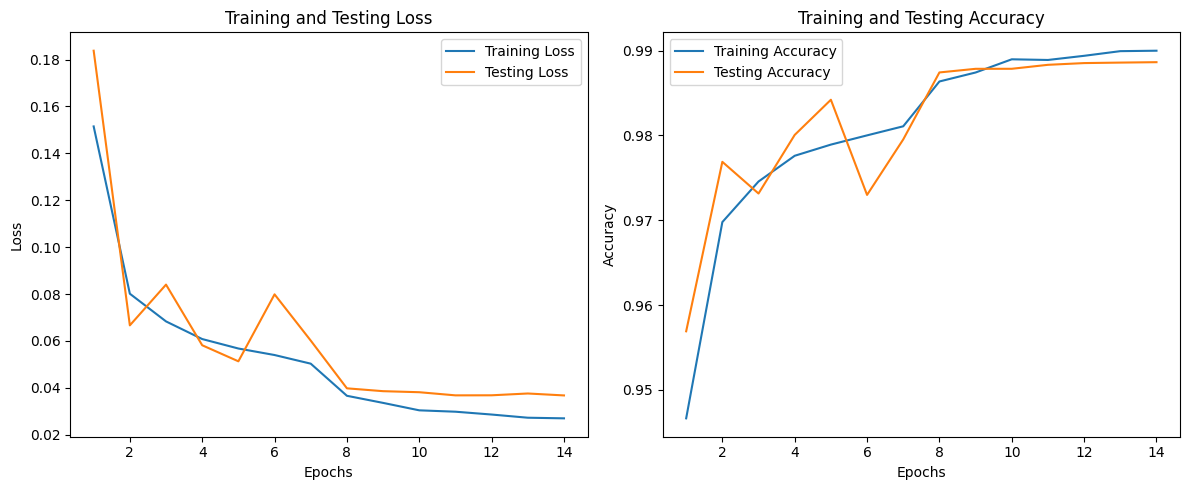

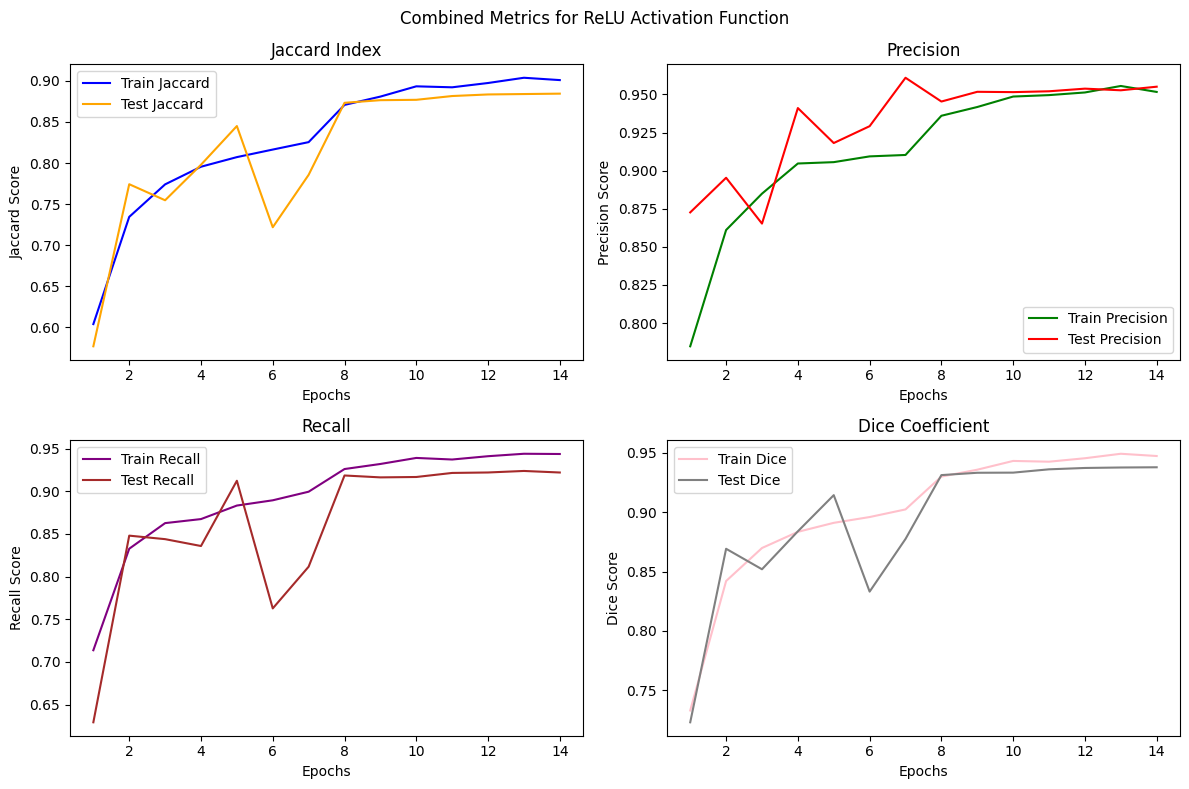

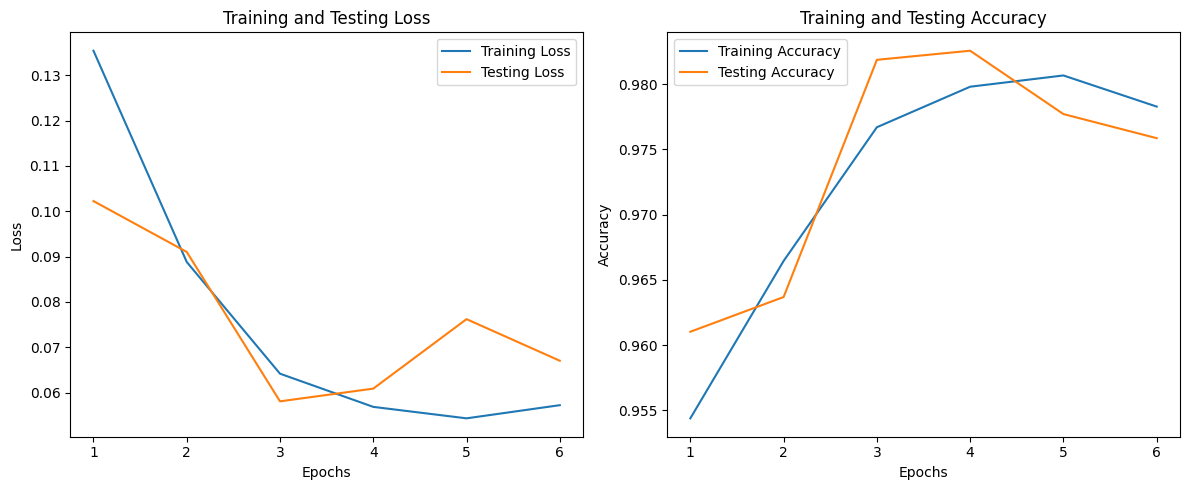

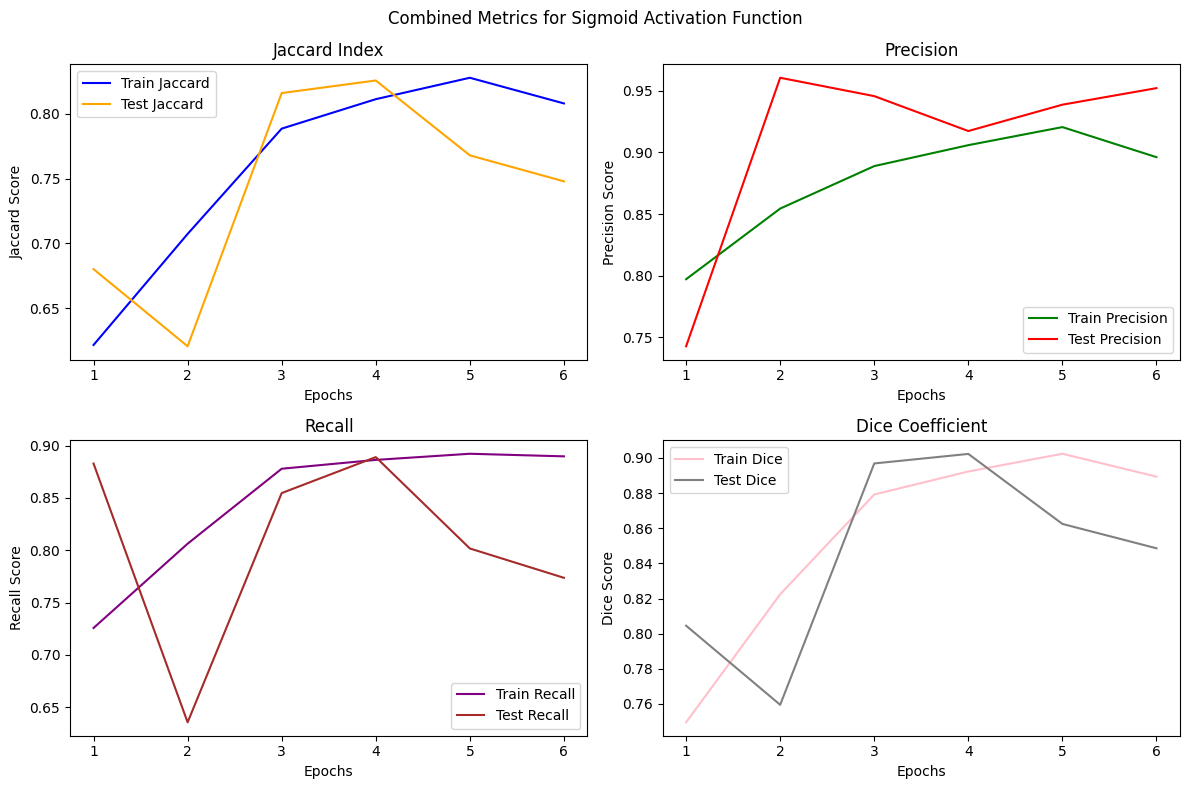

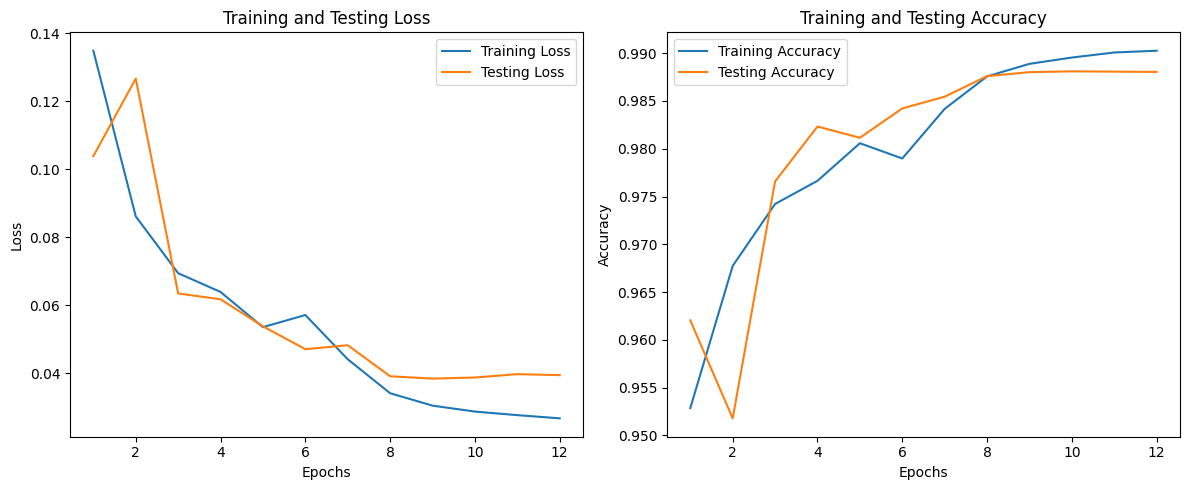

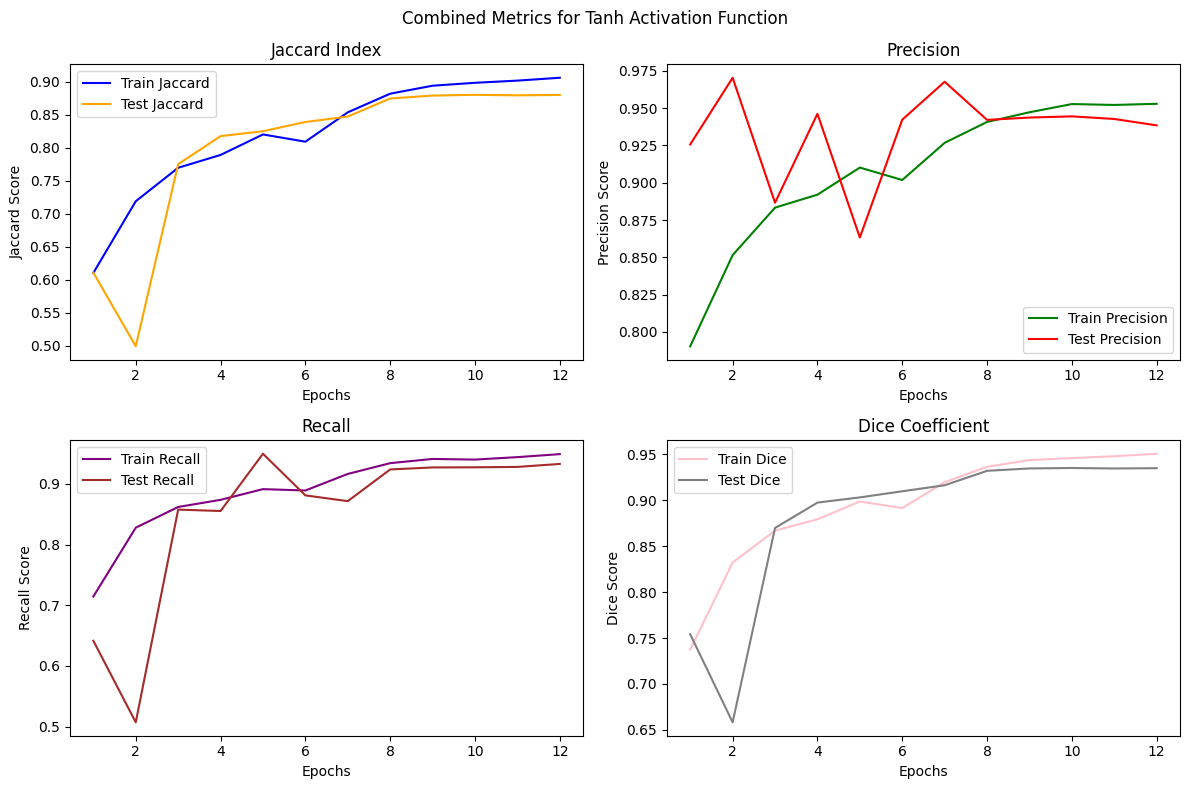

In [5]:
# Function to plot Loss and Accuracy from results dictionary
def plot_loss_and_accuracy(results):
    # Access values from the results dictionary
    train_losses = results.get('train_losses', [])
    test_losses = results.get('test_losses', [])
    train_accuracies = results.get('train_accuracies', [])
    test_accuracies = results.get('test_accuracies', [])
    
    # Check if data exists before plotting
    if not train_losses or not test_losses or not train_accuracies or not test_accuracies:
        print("Some data is missing; please check the results structure.")
        return
    
    epochs = range(1, len(train_losses) + 1)

    # Plot Losses
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Testing Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, test_accuracies, label='Testing Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Function to plot multiple metrics including Dice Coefficient from results dictionary
def plot_combined_metrics(results, title='Combined Metrics Plot'):
    # Access values from the results dictionary
    train_jaccard = results.get('train_jaccards', [])
    test_jaccard = results.get('test_jaccards', [])
    train_precision = results.get('train_precisions', [])
    test_precision = results.get('test_precisions', [])
    train_recall = results.get('train_recalls', [])
    test_recall = results.get('test_recalls', [])
    train_dice = results.get('train_dices', [])
    test_dice = results.get('test_dices', [])
    
    # Check if data exists before plotting
    if not all([train_jaccard, test_jaccard, train_precision, test_precision, train_recall, test_recall, train_dice, test_dice]):
        print("Some data is missing; please check the results structure.")
        return
    
    epochs = range(1, len(train_jaccard) + 1)

    plt.figure(figsize=(12, 8))

    # Jaccard
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_jaccard, label='Train Jaccard', color='blue')
    plt.plot(epochs, test_jaccard, label='Test Jaccard', color='orange')
    plt.title('Jaccard Index')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Score')
    plt.legend()

    # Precision
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_precision, label='Train Precision', color='green')
    plt.plot(epochs, test_precision, label='Test Precision', color='red')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision Score')
    plt.legend()

    # Recall
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_recall, label='Train Recall', color='purple')
    plt.plot(epochs, test_recall, label='Test Recall', color='brown')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall Score')
    plt.legend()

    # Dice
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_dice, label='Train Dice', color='pink')
    plt.plot(epochs, test_dice, label='Test Dice', color='gray')
    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage
plot_loss_and_accuracy(activation_metrics['ReLU'])
plot_combined_metrics(activation_metrics['ReLU'], title='Combined Metrics for ReLU Activation Function')
plot_loss_and_accuracy(activation_metrics['Sigmoid'])
plot_combined_metrics(activation_metrics['Sigmoid'], title='Combined Metrics for Sigmoid Activation Function')
plot_loss_and_accuracy(activation_metrics['Tanh'])
plot_combined_metrics(activation_metrics['Tanh'], title='Combined Metrics for Tanh Activation Function')
